In [30]:
import open3d as o3d
import numpy as np
from copy import deepcopy
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import torch
import os
from open_clip import create_model_from_pretrained, get_tokenizer, create_model_and_transforms
from text_encoder import get_encode_fn
from visualization_utils import visualize

In [8]:
tag = "rotterdam-siglip-more-data-corrupted" # "brooklyn-bridge-new" #
# tag = "buenos-aires-squared-v3"
model_type = "siglip"
crop_type = "highlight" #"highlight" #"full"

In [9]:
model, tokenizer, encode_text = get_encode_fn(model_type)

c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
path = f"../data/embedded_point_clouds/{tag}"
pcd = o3d.io.read_point_cloud(os.path.join(path, "generated_point_cloud.ply"))
pcd_colors = deepcopy(pcd.colors)
features = np.load(os.path.join(path, f"point_features_{crop_type}.npy")).astype(np.float16)
features = features.transpose(1, 0, 2)
print(features.shape, np.asarray(pcd.points).shape)
assert len(features) == len(pcd.points)

(500000, 4, 1152) (500000, 3)


In [10]:
o3d.visualization.draw_geometries([pcd])

In [ ]:
# print("We make a partial mesh of only the first half triangles.")
# import copy
# mesh1 = copy.deepcopy(meshy)
# mesh1.triangles = o3d.utility.Vector3iVector(
#     np.asarray(mesh1.triangles)[:len(mesh1.triangles) // 2, :])
# mesh1.triangle_normals = o3d.utility.Vector3dVector(
#     np.asarray(mesh1.triangle_normals)[:len(mesh1.triangle_normals) // 2, :])
# print(mesh1.triangles)
# o3d.visualization.draw_geometries([mesh1])

In [33]:
# from visualization_utils import grayscale_to_plasma
# # pcd.colors = o3d.utility.Vector3dVector(grayscale_to_plasma(sim[:,0]))
# #mesh = o3d.io.read_triangle_mesh("C:/MSC-Data/OpenCity/rotterdam/rotterdam.obj".replace('\\',"/"), True)
# mesh = o3d.io.read_triangle_mesh("C:/MSC-Data/OpenCity/buenos-aires-squared-shifted/buenos-aires-squared-shifted.obj".replace('\\',"/"), True)
# def set_pos(vis):
#     ctr = vis.get_view_control()
#     parameters = o3d.io.read_pinhole_camera_parameters("C:/Users/Valentin\PycharmProjects\OpenCity\sandbox\ScreenCamera_2024-05-26-16-43-45.json".replace('\\',"/"))
#     ctr.convert_from_pinhole_camera_parameters(parameters, True)
#     vis.update_renderer()
#     vis.update_geometry(mesh)

# o3d.visualization.draw_geometries_with_key_callbacks([mesh],
#                                                             {ord("Q"): set_pos},
#                                                             )

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [ ]:
# indices = (np.asarray(pcd.points)[: ,2] > 0) & (np.asarray(pcd.points)[: ,0] > 0) & ~(features[:,0] == 0).all(axis=1)
# pcd2 = pcd.select_by_index(np.where(indices)[0])
# sim2 = sim[indices, :]


# # ctr = o3d.visualizations.get_view_control()
# # parameters = o3d.io.read_pinhole_camera_parameters("C:/Users/Valentin\PycharmProjects\OpenCity\sandbox\ScreenCamera_2024-05-26-16-43-45.json".replace('\\',))
# # ctr.convert_from_pinhole_camera_parameters(parameters)

# visualize(pcd2, sim2[:,1], query)

## Urban inventory

In [29]:
queries = ["tree"] # ["tree", "building", "road", "tennis court", "river", "car", "sea / lake / canal", "university", "Depot Boijmans Van Beuningen"]

query_embed = encode_text(queries, model, tokenizer)
sim = features @ query_embed 
sim = sim.max(axis=1)
# sim = np.exp(sim)
    # sim = np.exp(sim) / (np.exp(sim) + np.exp(max_canonical_sim))
print(sim.shape)

for i, query in enumerate(queries):
    visualize(pcd, sim[:,i], query)

c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


(500000, 1)


In [12]:
sim.shape

(500000, 1)

### Age of building

In [14]:
queries_age = ["historic building", "old house", "traditional architecture", "modern building", "contemporary architecture", "new house", "house", "tree", "road", "grass"]
# queries_age = [ "old building", "modern building", "house", "tree", "road", "grass"]
query_embed_age = encode_text(queries_age, model, tokenizer)
sim_age = features @ query_embed_age
sim_age = sim_age.max(axis=1)
sim_norm_age = np.exp(sim_age) / np.exp(sim_age).sum(-1, keepdims=True)
print(sim_age.shape)

print(sim_age.shape)
sim_ratio = sim_age[:, :3].sum(axis=-1) - sim_age[:, 3:6].sum(axis=-1)
visualize(pcd, sim_ratio, "old / new ratio")

for i, query in enumerate(queries_age):
    visualize(pcd, sim_norm_age[:,i], query, normalize=False)

c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


(500000, 10)
(500000, 10)


## Social Dynamics

### population density

0.997186 0.0


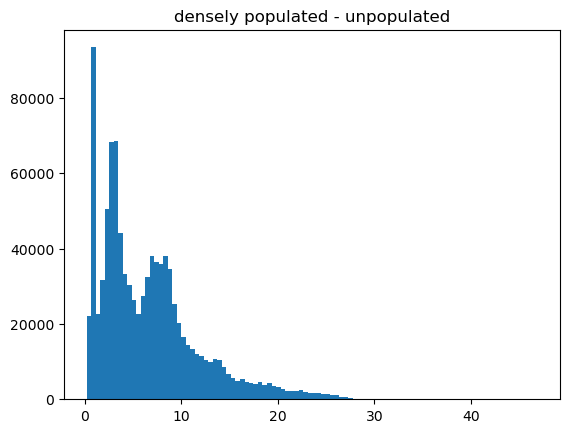

In [ ]:
queries = ["densely populated area", "loosely populated area", "unpopulated area", "nature", "urban area"]
query_embed = encode_text(queries, model, tokenizer)
sim = features @ query_embed 
sim = sim.max(axis=1)
visualize(np.exp(sim[:,0]- 0.5*sim[:,1] - 0.5 * sim[:, 3]), "densely populated - unpopulated")


### crime rate

c:\Users\Valentin\anaconda3\envs\Scraping\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


0.996096 0.0


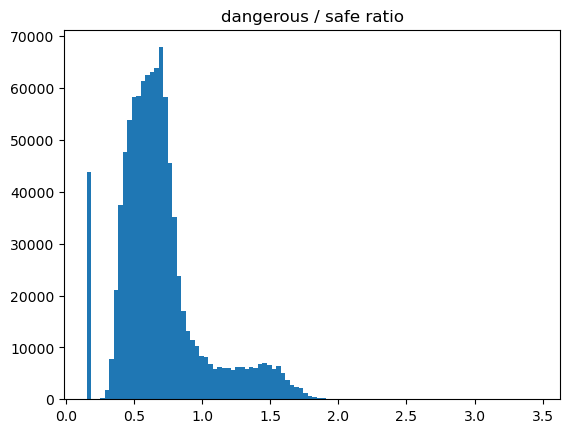

Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring
Switching coloring


In [ ]:
queries = ["dangerous neighborhood", "safe neighborhood", "nature",]

query_embed = encode_text(queries, model, tokenizer)
sim = features @ query_embed 
sim = sim.max(axis=1)

danger_ratio = sim[:,0] - (sim[:,1] + 0.1*sim[:,2])
danger_ratio = np.exp(danger_ratio)
danger_ratio[(features[:,0] == 0).all(axis=1)] = np.min(danger_ratio[(features[:,0] != 0).any(axis=1)])
visualize(danger_ratio, "dangerous / safe ratio")

#     visualize(sim[:,i], query)

### housing prices

(1000000, 7)
0.997351 0.0


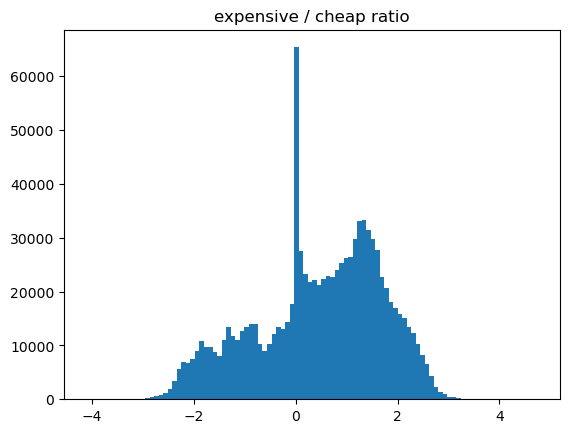

In [ ]:
queries = ["rich neighborhood", "expensive area", "poor neighborhood",  "cheap area", "nature", "urban area", "unpopulated area"]

query_embed = encode_text(queries, model, tokenizer)
sim = features @ query_embed 
sim = sim.max(axis=1)
print(sim.shape)

expensiveness_ratio = sim[:,:2].sum(axis=-1) - sim[:,2] - sim[:,3] + 0.1*sim[:,4]
visualize(expensiveness_ratio, "expensive / cheap ratio")